## Import libraries and dependencies

In [1]:
import pickle

from scipy.stats import uniform, randint

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import tqdm
import copy
import matplotlib.pyplot as plt

import time


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import os

os.chdir("/local-scratch/GlucoseProject/mobicom23_mobispectral/regression")

from evaluate import *
from utils import *
from dict_dataset import ImageList
from scipy.stats import pearsonr

import logging

from Architecture.MLP import MLPRegressorPyTorch

In [7]:
from utils import initialize_logger
# logging
log_dir = os.path.join(os.getcwd(), 'train.log')
logger = initialize_logger(log_dir)

In [2]:
#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using: {device}")

Device using: cuda


### Model architecture

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 200)
        # self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        # self.drop1 = nn.Dropout(p=0.2)
        
        self.fc2 = nn.Linear(200, 200)
        # self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        # self.drop2 = nn.Dropout(p=0.2)
        
        self.fc3 = nn.Linear(200, 1)

        # Initialize weights using He initialization
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = (self.relu1(self.fc1(x)))
        x = (self.relu2(self.fc2(x)))
        # x = (self.relu2(self.bn2(self.fc2(x))))
        # x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        # x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, 200)
        self.relu = nn.ReLU()
        self.output = nn.Linear(200, output_size)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [2]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'
step = 1

In [3]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data_temp.csv'
file_test = 'test_data_temp.csv'
step = 1

In [4]:
data_root = '../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

In [4]:
data_root = '../datasets/dataset_glucose/mobile/GooglePixel4XL'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

In [7]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')

# scaler = MinMaxScaler()
x_scaler = StandardScaler()
# x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
# y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
# y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

# for image in test_data:
#     image['sig'] = x_scaler.transform(image['sig'])
#     # Does not need to scale the label, inverse transform the prediction instead
#     # image['label'] = y_scaler.transform(image['label'].reshape(-1, 1))
    
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Loading hyper dataset
Loading hyper dataset
X_train shape:  (1275170, 204)
y_train shape:  (1275170,)
X_test shape:  (320580, 204)
y_test shape:  (320580,)


In [5]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'mobi')

# x_scaler = MinMaxScaler()
# x_scaler = StandardScaler()
x_scaler = RobustScaler()
y_scaler = RobustScaler()

X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

# for image in test_data:
#     image['sig'] = x_scaler.transform(image['sig'])
#     # Does not need to scale the label, inverse transform the prediction instead
#     # image['label'] = y_scaler.transform(image['label'].reshape(-1, 1))
    
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Loading Mobile dataset
Loading Mobile dataset
X_train shape:  (252933, 67)
y_train shape:  (252933, 1)
X_test shape:  (126346, 67)
y_test shape:  (126346, 1)


In [ ]:
# Step 1, 49 features selected, F score
selected_features_indices = [1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
X_train_selected = X_train[:, selected_features_indices]
# X_val_selected = X_val[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

test_data_selected = copy.deepcopy(test_data)

for image in test_data_selected:
    test_features = image['sig']
    test_features = scaler.transform(test_features)
    image['sig'] = test_features[:, selected_features_indices]

print("X_train_selected shape: ", X_train_selected.shape)
# print("X_val_selected shape: ", X_val_selected.shape)
print("X_test_selected shape: ", X_test_selected.shape)

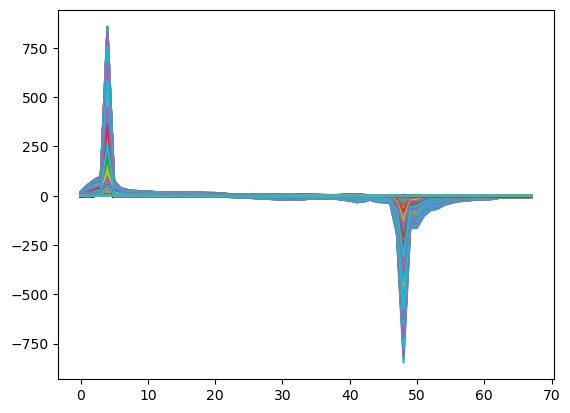

In [6]:
# After robust scaling
for row in X_train:
    plt.plot(row)

In [6]:
model = MLP(X_train.shape[1]).to(device)

lr = 0.001
num_epochs = 30000
loss_fn = nn.MSELoss().to(device)
# Early stopping parameters
tol = 1e-4
patience = 2
best_loss = float('inf')
trigger_times = 5
optimizer = optim.Adam(model.parameters(), lr)
trigger_counter = 0

batch_size = X_train.shape[0]
# batch_size = 128
batch_start = torch.arange(0, len(X_train), batch_size)
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

In [38]:
model = MLP(X_train.shape[1]).to(device)

num_epochs = 30000
loss_fn = nn.MSELoss().to(device)
patience = 5
best_loss = float('inf')
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
trigger_times = 5
trigger_counter = 0

alpha=0.0001
batch_size = X_train.shape[0]
batch_start = torch.arange(0, len(X_train), batch_size)
learning_rate='constant'
learning_rate_init=0.0001
# shuffle=True
# random_state=42
tol=1e-4
# verbose=False
# warm_start=False
# momentum=0.9
# nesterovs_momentum=True
# early_stopping=False
# validation_fraction=0.1
beta_1=0.9
beta_2=0.999
epsilon=1e-8

optimizer = optim.Adam(model.parameters(), lr=learning_rate_init)

In [39]:
# Convert training data to tensors
X_train_ = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_ = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
X_test_ = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_ = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

# training loop
for epoch in range(num_epochs):
    model.train()
    # with tqdm.tqdm(range(0, len(X_train_), batch_size), unit="batch", mininterval=0, disable=True) as bar:
    #     bar.set_description(f"Epoch {epoch + 1}")
    #     for start in bar:
    #         # end = start + batch_size
    #         # X_batch = X_train_[start:end]
    #         # y_batch = y_train_[start:end]
            
    #         # Forward pass
    #         y_pred = model(X_train_)
    #         loss = loss_fn(y_pred.squeeze(), y_train_.squeeze())
    #         # print(y_pred.shape, y_train_.shape)
            
    #         # Backward pass
    #         optimizer.zero_grad()
    #         loss.backward()
            
    #         # Update weights
    #         optimizer.step()
            
    #         # Print progress
    #         bar.set_postfix(mse=float(loss))

     # Forward pass
    y_pred = model(X_train_)
    loss = loss_fn(y_pred.squeeze(), y_train_.squeeze())
    # print(y_pred.shape, y_train_.shape)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Update weights
    optimizer.step()

    # Evaluate accuracy at the end of each epoch
    model.eval()
    with torch.no_grad():
        mse_train = loss_fn(model(X_train_).squeeze(), y_train_.squeeze()).item()
        y_pred = model(X_test_)
        mse_val = loss_fn(y_pred.squeeze(), y_test_.squeeze()).item()
    
    history.append(mse_val)
    
    if mse_val < best_loss:
        best_loss = mse_val
        best_weights = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), './Models/FFNN_test_Hyper2.0.pth')

    # Early stopping
    if mse_val < best_loss:
        best_loss = mse_val
        # If the model does not improve more than tol, trigger the counter
        if best_loss - mse_val > tol:
            trigger_counter = 0
        else:
            trigger_counter += 1
    else:
        trigger_counter += 1
        if trigger_counter >= trigger_times:
            print(f"Early stopping on epoch {epoch + 1}")
            break
    
    # Print train loss and validation loss
    if epoch % 20 == 0:
        print(f"Epoch {epoch + 1}, train loss: {mse_train}, validation loss: {mse_val}")
    
        

/tmp/ipykernel_97900/3420872856.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_ = torch.tensor(X_test, dtype=torch.float32).to(device)


Epoch 1, train loss: 4.13218355178833, validation loss: 3.7690670490264893
Early stopping on epoch 5


In [9]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# import logging



# # Convert training data to tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# # Create a training dataset and training loader
# train_dataset = TensorDataset(X_train, y_train)
# # Create a training dataset and training loader
# test_dataset = TensorDataset(X_test, y_test)


# # Define the size of the validation set (e.g., 20% of the dataset)
# val_size = int(0.2 * len(train_dataset))
# train_size = len(train_dataset) - val_size

# # Split the dataset into training and validation sets
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


# # Training loop with validation
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward + backward + optimize
#         outputs = model(inputs)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     avg_train_loss = running_loss / len(train_loader)

#     # Validation step
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = loss_fn(outputs, labels)
#             val_loss += loss.item()
#     avg_val_loss = val_loss / len(val_loader)

#     logging.info(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

#     # Early stopping
#     if avg_val_loss < best_loss:
#         best_loss = avg_val_loss
#         trigger_times = 0
#         # Optionally save the best model
#         torch.save(model.state_dict(), 'Models/FFNN_test3.2_no_trans.pth')
#     else:
#         trigger_times += 1
#         if trigger_times >= patience:
#             logging.info("Early stopping triggered.")
#             break


## Evaluation

In [16]:
def evaluate_clarke_error_grid(y_pred, y_test, show=False):
    try:
        plt.figure()
        plt2, zone = clarke_error_grid(y_test, y_pred,
                                       'Clinical Standard Error Grid for Glucose Reference and Predicted Value')
        logging.info("Clarke Error Grid analysis completed.")
        if show:
            plt2.show()
        return zone
    except Exception as e:
        logging.error("Failed to generate Clarke Error Grid: {}".format(str(e)))


def evaluate_ard(y_pred, y_test, show=False):
    try:
        y_test = y_test.ravel()
        y_pred = y_pred.ravel()
        ard = ARD(y_pred, y_test)
        logging.info('ARD: {}'.format(ard))
        ard_accurate = np.sum(ard < 0.2)
        percentage_ard_accurate = ard_accurate * 100 / len(ard)
        logging.info(
            'Percentage of clinical accurate glucose concentration (ARD < 0.2): {}/{} = {:.2f}%'.format(ard_accurate,
                                                                                                        len(ard),
                                                                                                        percentage_ard_accurate))
        if show:
            show_ARD(ard)
        return ard
    except Exception as e:
        logging.error("Failed to calculate ARD: {}".format(str(e)))


def evaluate_pearson_correlation(y_pred, y_test):
    try:
        y_test = y_test.ravel()
        y_pred = y_pred.ravel()
        corr, _ = pearsonr(y_pred, y_test)
        logging.info('Pearson correlation coefficient: {:.3f}'.format(corr))

        return corr
    except Exception as e:
        logging.error("Failed to calculate Pearson correlation: {}".format(str(e)))

In [ ]:
print(model(X_test).shape)
print(y_test.shape)
print(y_test_.shape)

In [23]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(438360, 204) (438360,) torch.Size([4225, 204]) (223665,)


In [26]:
print(X_test.shape)
print(X_test_.shape)

torch.Size([172705, 200])
torch.Size([4225, 200])


ARD by images:  [0.40650682 0.19234754 0.3764377  0.04936235 0.10001359 0.30893936
 0.29176915 0.24028186 0.95419198 0.15757836 0.00891719 0.26458486
 0.09941008 0.17122562 1.11642203 0.1616456  0.11119871 0.28691511
 0.2054361  0.20851279 0.36132474 0.04845525 0.28130624 0.52974279
 0.08506343 0.1805571  0.03002808 0.40552779 0.18580078 0.24021886
 0.62339501 0.40763459 0.05468309 0.00536406 0.39728435 0.3564698
 0.20968224 0.14398689 0.26123035 0.01520671 0.09223118]
Average ARD:  0.2591924423519346


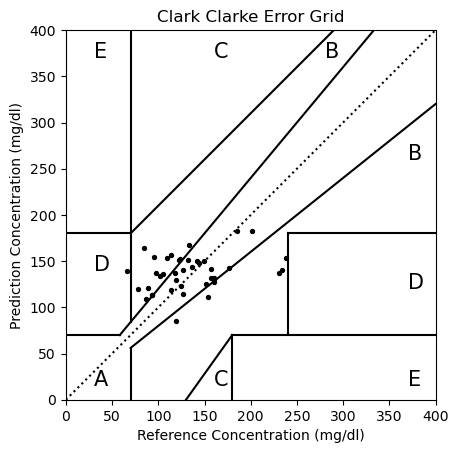

<Figure size 640x480 with 0 Axes>

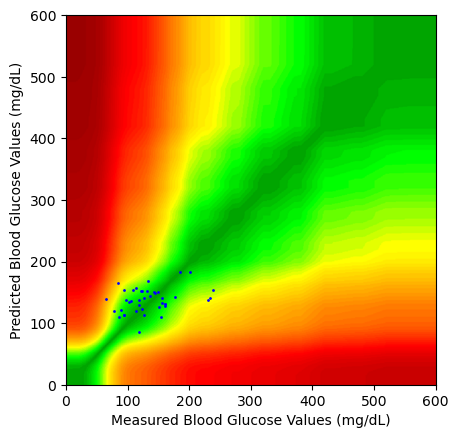

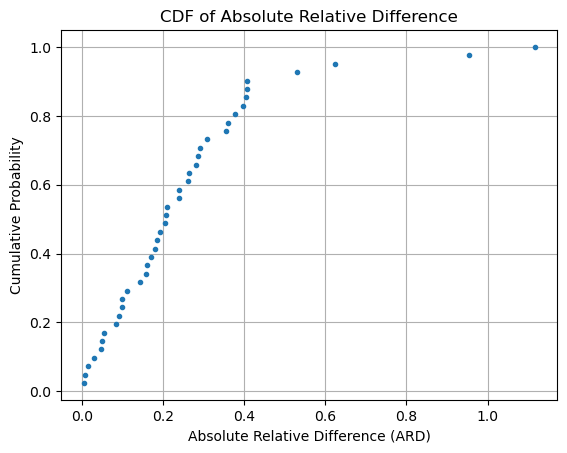

<Figure size 640x480 with 0 Axes>

In [36]:
model = MLP(X_train.shape[1]).to(device)
model.eval()
with torch.no_grad():

    # # Save the trained model
    # torch.save(model.state_dict(), './Models/FFNN_test4.0.pth')


    # # Load the trained model
    model.load_state_dict(torch.load("./Models/FFNN_test_Hyper2.0.pth"))

    predictions = []
    labels = []

    predictions = np.asarray(predictions)
    labels = np.asarray(labels)

    # X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

    # for i in range(len(test_data)):
    #     test_img = test_data[i]
    #     X_test_scaled = scaler_X.transform(test_img['sig'])
    #     X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    #     y_pred = model(X_test_scaled).cpu().numpy()
    #     # y_pred need to retransform to the original scale
    #     y_pred = scaler_y.inverse_transform(y_pred)
    #     y_pred = y_pred.mean()
    #     predictions = np.append(predictions, y_pred)
    #     labels = np.append(labels, test_img['label'][1])

    for i in range(len(test_data)):
        test_img = test_data[i]
        X_test_ = test_img['sig']
        X_test_ = x_scaler.transform(X_test_)
        X_test_ = torch.tensor(X_test_, dtype=torch.float32).to(device)
        y_pred = cp.asnumpy(model(X_test_))
        y_pred_mean = y_pred.mean()
        y_pred_mean = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
        predictions = np.append(predictions, y_pred_mean)
        labels = np.append(labels, test_img['label'][1])

    # y_pred = model(X_test).cpu().numpy()
    # print(f"ARD by signatures: {ARD(y_pred, y_test).mean()}" )
    # evaluate_image(test_data, model=model)

    ard = ARD(predictions, labels)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())


    plt2, _ = clarke_error_grid(predictions, labels, 'Clark')
    plt2.show()
    plot_surveillance_error_grid(predictions, labels, '../graph/SEG_background/seg600.png')
    calculate_seg_risks(predictions, labels, 3)
    CDF(ard)


In [ ]:
print(model(X_train))

In [10]:
print(predictions.shape)
print(labels.shape)

(53,)
(53,)


In [11]:
for i in range(len(test_data)):
        test_img = test_data[i]
        X_test = test_img['sig']
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        print(X_test)
        y_test = test_img['label'][1]
        print(y_test)

tensor([[-1.5276, -1.5150, -1.6188,  ..., -1.5436, -1.5952, -1.7861],
        [-1.8857, -1.8686, -1.6188,  ..., -1.4641, -1.4273, -1.6619],
        [-1.5276, -1.5150, -1.9505,  ..., -1.3847, -1.4273, -1.6619],
        ...,
        [ 0.6206,  0.9597,  0.3716,  ..., -0.1927, -0.3358, -0.1712],
        [ 0.6206,  0.9597,  0.0398,  ..., -0.2722, -0.2895, -0.0469],
        [ 0.6206,  0.6061,  0.3716,  ..., -0.2722, -0.3358, -0.1712]],
       device='cuda:0')
165.76744
tensor([[-1.7835, -1.4410, -1.1244,  ..., -1.6075, -1.4601, -1.7648],
        [-1.4153, -1.8013, -1.4697,  ..., -1.5272, -1.4885, -1.5133],
        [-1.7835, -1.8013, -1.4697,  ..., -1.4468, -1.4032, -1.5133],
        ...,
        [ 0.7943,  0.0000,  0.9473,  ..., -0.5626, -0.5053, -0.5073],
        [ 0.4260,  0.7205,  0.9473,  ..., -0.4385, -0.5921, -0.5073],
        [ 0.4260,  0.7205,  0.9473,  ..., -0.4019, -0.6362, -0.3815]],
       device='cuda:0')
109.91102
tensor([[-1.5574, -1.5801, -1.6030,  ..., -1.5004, -1.5149, -1.5

In [7]:
model = MLPRegressorPyTorch()
save_model(model, './Models/FFNN_test_ToF1.0.pth')

In [6]:
save_model(model, './Models/FFNN_test_hyper1.0.pth')

In [4]:
print(X_train.shape)

(1275170, 204)


cuda
Epoch 1/200, Training Loss: 1281.810378, Validation Loss: 773.923462
Epoch 2/200, Training Loss: 325.341821, Validation Loss: 656.345886
Epoch 3/200, Training Loss: 234.622740, Validation Loss: 626.088440
Epoch 4/200, Training Loss: 197.012129, Validation Loss: 629.117920
Epoch 5/200, Training Loss: 174.297229, Validation Loss: 581.017761
Epoch 6/200, Training Loss: 158.360678, Validation Loss: 554.384094
Epoch 7/200, Training Loss: 146.310464, Validation Loss: 545.424255
Epoch 8/200, Training Loss: 136.929362, Validation Loss: 560.229370
Epoch 9/200, Training Loss: 129.585342, Validation Loss: 572.942749
Epoch 10/200, Training Loss: 122.972437, Validation Loss: 560.691589
Epoch 11/200, Training Loss: 117.739840, Validation Loss: 619.548157
Epoch 12/200, Training Loss: 113.173780, Validation Loss: 596.379089
Epoch 13/200, Training Loss: 109.153692, Validation Loss: 554.062866
Epoch 14/200, Training Loss: 105.815066, Validation Loss: 541.620300
Epoch 15/200, Training Loss: 102.5609

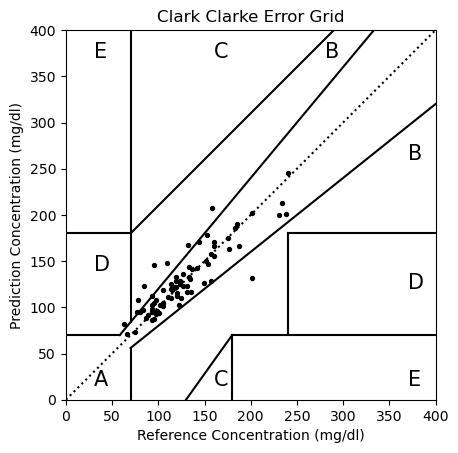

<Figure size 640x480 with 0 Axes>

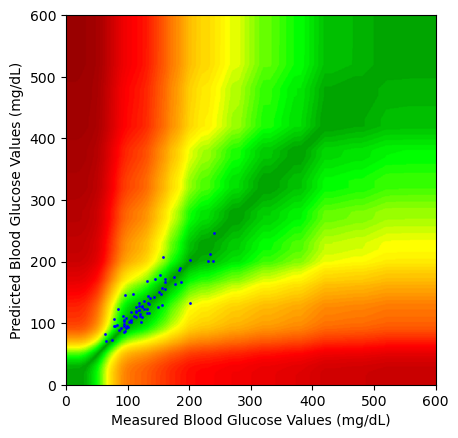

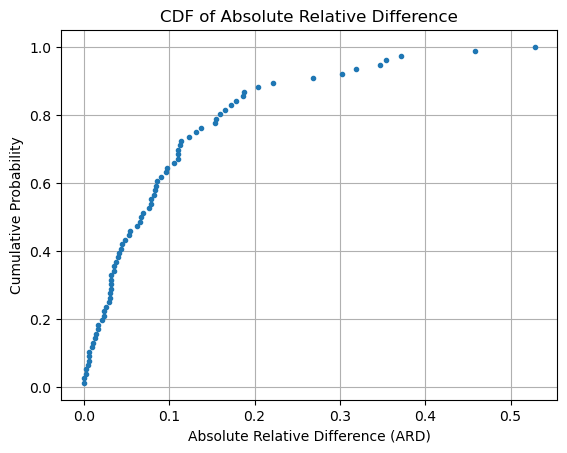

<Figure size 640x480 with 0 Axes>

In [19]:
model = MLPRegressorPyTorch((200, 100, 16), random_state=42, batch_size=1024, learning_rate_init=0.001, max_iter=200, verbose=True, alpha=0.001, n_iter_no_change=10, tol=1)
model.fit(X_train, y_train, X_val=X_test, y_val=y_test)
save_model(model, './Models/FFNN_hyper_204.pth')
# model = load_model('./Models/FFNN_test_hyper_200200_test.pth')

with torch.no_grad():

    # # Save the trained model
    # torch.save(model.state_dict(), './Models/FFNN_test4.0.pth')


    # # Load the trained model
    # model.load_state_dict(torch.load("./Models/FFNN_test_ToF1.0.pth"))

    # model = load_model('./Models/FFNN_hyper_204.pth')
    predictions = []
    labels = []

    predictions = np.asarray(predictions)
    labels = np.asarray(labels)

    # X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

    # for i in range(len(test_data)):
    #     test_img = test_data[i]
    #     X_test_scaled = scaler_X.transform(test_img['sig'])
    #     X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    #     y_pred = model(X_test_scaled).cpu().numpy()
    #     # y_pred need to retransform to the original scale
    #     y_pred = scaler_y.inverse_transform(y_pred)
    #     y_pred = y_pred.mean()
    #     predictions = np.append(predictions, y_pred)
    #     labels = np.append(labels, test_img['label'][1])

    for i in range(len(test_data)):
        test_img = test_data[i]
        X_test_ = test_img['sig']
        X_test_ = x_scaler.transform(X_test_)
        X_test_ = cp.asnumpy(X_test_)
        y_pred = model.predict(X_test_)
        y_pred_mean = y_pred.mean()
        # y_pred_mean = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
        predictions = np.append(predictions, y_pred_mean)
        labels = np.append(labels, test_img['label'][1])

    # y_pred = model(X_test).cpu().numpy()
    # print(f"ARD by signatures: {ARD(y_pred, y_test).mean()}" )
    # evaluate_image(test_data, model=model)

    ard = ARD(predictions, labels)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())


    plt2, _ = clarke_error_grid(predictions, labels, 'Clark')
    plt2.show()
    plot_surveillance_error_grid(predictions, labels, '../graph/SEG_background/seg600.png')
    calculate_seg_risks(predictions, labels, 3)
    CDF(ard)


<Figure size 640x480 with 0 Axes>

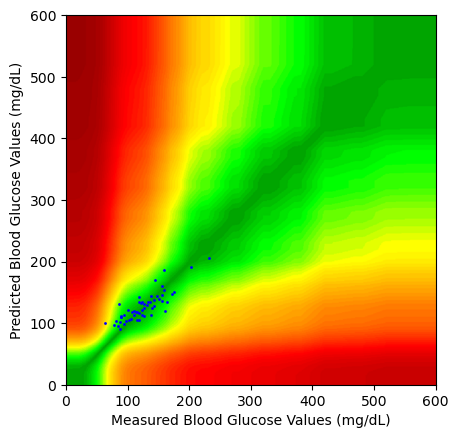

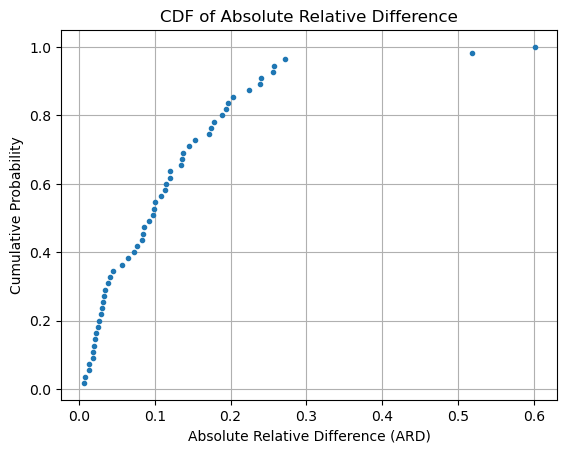

<Figure size 640x480 with 0 Axes>

In [6]:
plot_surveillance_error_grid(predictions, labels, '../graph/SEG_background/seg600.png')
calculate_seg_risks(predictions, labels, 3)
CDF(ard)

In [ ]:
model = MLPRegressorPyTorch((200, 100, 16), random_state=42, batch_size=1024, learning_rate_init=0.001, max_iter=200, verbose=True, n_iter_no_change=5, tol=1)
model.fit(X_train, y_train)
save_model(model, './Models/FFNN_test_hyper_200200_test.pth')
# model = load_model('./Models/FFNN_test_hyper_200200_test.pth')

with torch.no_grad():

    # # Save the trained model
    # torch.save(model.state_dict(), './Models/FFNN_test4.0.pth')


    # # Load the trained model
    # model.load_state_dict(torch.load("./Models/FFNN_test_ToF1.0.pth"))

    # model = load_model('./Models/FFNN_test_hyper_200200_test.pth')
    predictions = []
    labels = []

    predictions = np.asarray(predictions)
    labels = np.asarray(labels)

    # X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

    # for i in range(len(test_data)):
    #     test_img = test_data[i]
    #     X_test_scaled = scaler_X.transform(test_img['sig'])
    #     X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    #     y_pred = model(X_test_scaled).cpu().numpy()
    #     # y_pred need to retransform to the original scale
    #     y_pred = scaler_y.inverse_transform(y_pred)
    #     y_pred = y_pred.mean()
    #     predictions = np.append(predictions, y_pred)
    #     labels = np.append(labels, test_img['label'][1])

    for i in range(len(test_data)):
        test_img = test_data[i]
        X_test = test_img['sig']
        X_test = x_scaler.transform(X_test)
        X_test = cp.asnumpy(X_test)
        y_pred = model.predict(X_test)
        y_pred_mean = y_pred.mean()
        y_pred_mean = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
        predictions = np.append(predictions, y_pred_mean)
        labels = np.append(labels, test_img['label'][1])

    # y_pred = model(X_test).cpu().numpy()
    # print(f"ARD by signatures: {ARD(y_pred, y_test).mean()}" )
    # evaluate_image(test_data, model=model)

    ard = ARD(predictions, labels)
    print("ARD by images: ", ard)
    print("Average ARD: ", ard.mean())


    plt2, _ = clarke_error_grid(predictions, labels, 'Clark')
    plt2.show()
    plot_surveillance_error_grid(predictions, labels, '../graph/SEG_background/seg600.png')
    calculate_seg_risks(predictions, labels, 3)
    CDF(ard)
